# Import Libraries 

In [1]:
from tqdm import tqdm
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from   torchvision import datasets, transforms
import torch.optim as optim
from   torch.optim.lr_scheduler import StepLR
from   torchinfo import summary

import albumentations as A
from   albumentations.pytorch import ToTensorV2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import models as cifar_models
import utils as myutils

# Set the GPU device

In [2]:
# Is GPU available
device = torch.device("cpu")
is_gpu_available = False

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda:0")
    is_gpu_available = True
elif torch.backends.mps.is_available():
    print("Apple MPS is available")
    device = torch.device("mps:0")
    is_gpu_available = True

torch.set_default_device(device)

Apple MPS is available


# Download and prepare the dataset

In [3]:
# To get over the following error:
# URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
batch_size = 2048
# Train Phase transformations
train_transforms = myutils.Transforms(transforms=A.Compose([
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, 
        border_mode=4, value=None, mask_value=None, shift_limit_x=None, shift_limit_y=None, 
        rotate_method='largest_box', always_apply=False, p=0.5,
    ),
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
        min_width=16, fill_value=0.48, mask_fill_value=None, always_apply=False, p=0.5,
    ),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Test Phase transformations
test_transforms = myutils.Transforms(transforms=A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Data
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Data loaders
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True) if is_gpu_available else dict(shuffle=True, batch_size=64)

# train dataloader
train_data_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
# test dataloader
test_data_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print("classes: ", train_data.class_to_idx)
# {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
classes:  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## Look at the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['image'])


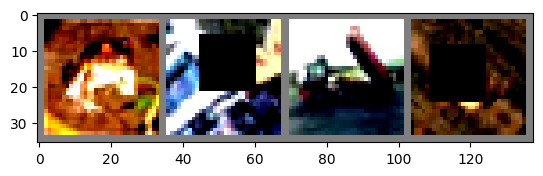

frog  truck truck deer 


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
data, labels = next(dataiter)
print(data.keys())
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
imshow(torchvision.utils.make_grid(data['image'][:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Model

# Summary

In [6]:
model = cifar_models.Net().to(device)
summary(model=model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           4,736
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 32, 32]           64
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           832
│    └─Conv2d: 2-5                       [1, 64, 32, 32]           2,112
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 64, 32, 32]           128
│    └─Dropout: 2-8                      [1, 64, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 30, 30]           --
│    └─Conv2d: 2-9                       [1, 64, 30, 30]           36,928
│  

# Train and test the model

In [7]:
model = cifar_models.Net().to(device)

criterion = F.nll_loss
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 100
for epoch in range(EPOCHS):
    # Train
    train_epoch_accuracy = myutils.train(model, train_data_loader, criterion, optimizer, epoch, train_losses, train_acc, device)
    # scheduler.step()
    # Test
    test_epoch_accuracy = myutils.test(model, test_data_loader, epoch, test_losses, test_acc, device)
    # 
    if train_epoch_accuracy >= 85 or test_epoch_accuracy >= 85:
        break

Epoch=0 Batch_id=24 Loss=1.9592022895812988 Accuracy=20.80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:47<00:00,  1.89s/it]



Test set: Average loss: 2.0567, Accuracy: 2216/10000 (22.16%)



Epoch=1 Batch_id=24 Loss=1.8476155996322632 Accuracy=28.64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.8129, Accuracy: 3299/10000 (32.99%)



Epoch=2 Batch_id=24 Loss=1.7635080814361572 Accuracy=33.08: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.7782, Accuracy: 3572/10000 (35.72%)



Epoch=3 Batch_id=24 Loss=1.723578691482544 Accuracy=34.22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.6578, Accuracy: 3926/10000 (39.26%)



Epoch=4 Batch_id=24 Loss=1.6867365837097168 Accuracy=36.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.6121, Accuracy: 4072/10000 (40.72%)



Epoch=5 Batch_id=24 Loss=1.6110255718231201 Accuracy=38.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.5838, Accuracy: 4303/10000 (43.03%)



Epoch=6 Batch_id=24 Loss=1.5972110033035278 Accuracy=40.46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.5078, Accuracy: 4554/10000 (45.54%)



Epoch=7 Batch_id=24 Loss=1.565569281578064 Accuracy=41.12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.5033, Accuracy: 4508/10000 (45.08%)



Epoch=8 Batch_id=24 Loss=1.5433365106582642 Accuracy=41.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.4457, Accuracy: 4741/10000 (47.41%)



Epoch=9 Batch_id=24 Loss=1.5007518529891968 Accuracy=43.93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.4038, Accuracy: 4905/10000 (49.05%)



Epoch=10 Batch_id=24 Loss=1.5077146291732788 Accuracy=44.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3989, Accuracy: 4954/10000 (49.54%)



Epoch=11 Batch_id=24 Loss=1.4799375534057617 Accuracy=45.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3564, Accuracy: 5094/10000 (50.94%)



Epoch=12 Batch_id=24 Loss=1.4485968351364136 Accuracy=45.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3975, Accuracy: 4898/10000 (48.98%)



Epoch=13 Batch_id=24 Loss=1.4212324619293213 Accuracy=46.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3517, Accuracy: 5103/10000 (51.03%)



Epoch=14 Batch_id=24 Loss=1.4604765176773071 Accuracy=47.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3397, Accuracy: 5218/10000 (52.18%)



Epoch=15 Batch_id=24 Loss=1.4280520677566528 Accuracy=47.39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.3217, Accuracy: 5225/10000 (52.25%)



Epoch=16 Batch_id=24 Loss=1.3651901483535767 Accuracy=48.72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.53s/it]



Test set: Average loss: 1.2901, Accuracy: 5363/10000 (53.63%)



Epoch=17 Batch_id=24 Loss=1.360634684562683 Accuracy=49.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.53s/it]



Test set: Average loss: 1.2865, Accuracy: 5386/10000 (53.86%)



Epoch=18 Batch_id=24 Loss=1.3472964763641357 Accuracy=49.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [17:59<00:00, 43.16s/it]



Test set: Average loss: 1.2623, Accuracy: 5457/10000 (54.57%)



Epoch=19 Batch_id=24 Loss=1.3811699151992798 Accuracy=49.77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [15:50<00:00, 38.02s/it]



Test set: Average loss: 1.2922, Accuracy: 5348/10000 (53.48%)



Epoch=20 Batch_id=24 Loss=1.3467371463775635 Accuracy=49.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.53s/it]



Test set: Average loss: 1.2868, Accuracy: 5373/10000 (53.73%)



Epoch=21 Batch_id=24 Loss=1.3457890748977661 Accuracy=50.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.2355, Accuracy: 5613/10000 (56.13%)



Epoch=22 Batch_id=24 Loss=1.335208535194397 Accuracy=50.61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.2368, Accuracy: 5620/10000 (56.20%)



Epoch=23 Batch_id=24 Loss=1.3170090913772583 Accuracy=51.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.2339, Accuracy: 5618/10000 (56.18%)



Epoch=24 Batch_id=24 Loss=1.2847604751586914 Accuracy=52.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1924, Accuracy: 5802/10000 (58.02%)



Epoch=25 Batch_id=24 Loss=1.302700400352478 Accuracy=52.63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.1821, Accuracy: 5813/10000 (58.13%)



Epoch=26 Batch_id=24 Loss=1.2549318075180054 Accuracy=52.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.1900, Accuracy: 5808/10000 (58.08%)



Epoch=27 Batch_id=24 Loss=1.2734743356704712 Accuracy=53.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.1552, Accuracy: 5956/10000 (59.56%)



Epoch=28 Batch_id=24 Loss=1.2522566318511963 Accuracy=53.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.1435, Accuracy: 5975/10000 (59.75%)



Epoch=29 Batch_id=24 Loss=1.2522574663162231 Accuracy=53.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.1443, Accuracy: 5967/10000 (59.67%)



Epoch=30 Batch_id=24 Loss=1.2153050899505615 Accuracy=54.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1544, Accuracy: 5899/10000 (58.99%)



Epoch=31 Batch_id=24 Loss=1.244493842124939 Accuracy=54.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1323, Accuracy: 5995/10000 (59.95%)



Epoch=32 Batch_id=24 Loss=1.2010748386383057 Accuracy=54.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1214, Accuracy: 6022/10000 (60.22%)



Epoch=33 Batch_id=24 Loss=1.2019222974777222 Accuracy=53.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1482, Accuracy: 5980/10000 (59.80%)



Epoch=34 Batch_id=24 Loss=1.2147397994995117 Accuracy=55.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.1504, Accuracy: 5918/10000 (59.18%)



Epoch=35 Batch_id=24 Loss=1.2099710702896118 Accuracy=55.38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0940, Accuracy: 6095/10000 (60.95%)



Epoch=36 Batch_id=24 Loss=1.195451021194458 Accuracy=56.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0830, Accuracy: 6134/10000 (61.34%)



Epoch=37 Batch_id=24 Loss=1.1841741800308228 Accuracy=55.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1621, Accuracy: 5832/10000 (58.32%)



Epoch=38 Batch_id=24 Loss=1.194624662399292 Accuracy=55.94: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0804, Accuracy: 6200/10000 (62.00%)



Epoch=39 Batch_id=24 Loss=1.1447398662567139 Accuracy=56.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0693, Accuracy: 6199/10000 (61.99%)



Epoch=40 Batch_id=24 Loss=1.1898385286331177 Accuracy=57.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0447, Accuracy: 6349/10000 (63.49%)



Epoch=41 Batch_id=24 Loss=1.145556092262268 Accuracy=57.57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1111, Accuracy: 6115/10000 (61.15%)



Epoch=42 Batch_id=24 Loss=1.144527554512024 Accuracy=57.14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0614, Accuracy: 6270/10000 (62.70%)



Epoch=43 Batch_id=24 Loss=1.1379563808441162 Accuracy=56.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.0282, Accuracy: 6345/10000 (63.45%)



Epoch=44 Batch_id=24 Loss=1.1089555025100708 Accuracy=58.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.0672, Accuracy: 6236/10000 (62.36%)



Epoch=45 Batch_id=24 Loss=1.1264214515686035 Accuracy=57.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0201, Accuracy: 6426/10000 (64.26%)



Epoch=46 Batch_id=24 Loss=1.082896113395691 Accuracy=58.51: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0615, Accuracy: 6257/10000 (62.57%)



Epoch=47 Batch_id=24 Loss=1.0879772901535034 Accuracy=58.64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.0422, Accuracy: 6309/10000 (63.09%)



Epoch=48 Batch_id=24 Loss=1.1262480020523071 Accuracy=58.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.0194, Accuracy: 6355/10000 (63.55%)



Epoch=49 Batch_id=24 Loss=1.1370842456817627 Accuracy=58.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.0710, Accuracy: 6228/10000 (62.28%)



Epoch=50 Batch_id=24 Loss=1.1121097803115845 Accuracy=58.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.0229, Accuracy: 6394/10000 (63.94%)



Epoch=51 Batch_id=24 Loss=1.094741940498352 Accuracy=59.76: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9933, Accuracy: 6488/10000 (64.88%)



Epoch=52 Batch_id=24 Loss=1.0789321660995483 Accuracy=59.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.0290, Accuracy: 6387/10000 (63.87%)



Epoch=53 Batch_id=24 Loss=1.0699492692947388 Accuracy=59.89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 0.9771, Accuracy: 6540/10000 (65.40%)



Epoch=54 Batch_id=24 Loss=1.0893629789352417 Accuracy=59.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.0967, Accuracy: 6184/10000 (61.84%)



Epoch=55 Batch_id=24 Loss=1.1201555728912354 Accuracy=58.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 0.9704, Accuracy: 6540/10000 (65.40%)



Epoch=56 Batch_id=24 Loss=1.0764507055282593 Accuracy=60.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9838, Accuracy: 6525/10000 (65.25%)



Epoch=57 Batch_id=24 Loss=1.072898507118225 Accuracy=60.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 0.9894, Accuracy: 6511/10000 (65.11%)



Epoch=58 Batch_id=24 Loss=1.0528618097305298 Accuracy=60.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 0.9672, Accuracy: 6612/10000 (66.12%)



Epoch=59 Batch_id=24 Loss=1.0439934730529785 Accuracy=60.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 0.9756, Accuracy: 6540/10000 (65.40%)



Epoch=60 Batch_id=24 Loss=1.0129159688949585 Accuracy=60.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9646, Accuracy: 6608/10000 (66.08%)



Epoch=61 Batch_id=24 Loss=1.0377764701843262 Accuracy=61.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9720, Accuracy: 6595/10000 (65.95%)



Epoch=62 Batch_id=24 Loss=1.0465387105941772 Accuracy=61.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9350, Accuracy: 6678/10000 (66.78%)



Epoch=63 Batch_id=24 Loss=1.0205357074737549 Accuracy=60.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9606, Accuracy: 6634/10000 (66.34%)



Epoch=64 Batch_id=24 Loss=0.9949500560760498 Accuracy=61.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9636, Accuracy: 6588/10000 (65.88%)



Epoch=65 Batch_id=24 Loss=1.0411159992218018 Accuracy=61.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9648, Accuracy: 6610/10000 (66.10%)



Epoch=66 Batch_id=24 Loss=0.9860288500785828 Accuracy=62.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9208, Accuracy: 6749/10000 (67.49%)



Epoch=67 Batch_id=24 Loss=1.031773567199707 Accuracy=62.11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.0020, Accuracy: 6448/10000 (64.48%)



Epoch=68 Batch_id=24 Loss=1.0164369344711304 Accuracy=61.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9457, Accuracy: 6637/10000 (66.37%)



Epoch=69 Batch_id=24 Loss=0.9989543557167053 Accuracy=62.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9474, Accuracy: 6679/10000 (66.79%)



Epoch=70 Batch_id=24 Loss=0.9981381297111511 Accuracy=62.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9402, Accuracy: 6678/10000 (66.78%)



Epoch=71 Batch_id=24 Loss=1.0144047737121582 Accuracy=62.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9469, Accuracy: 6676/10000 (66.76%)



Epoch=72 Batch_id=24 Loss=1.0176664590835571 Accuracy=62.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9191, Accuracy: 6768/10000 (67.68%)



Epoch=73 Batch_id=24 Loss=0.9708518981933594 Accuracy=63.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9254, Accuracy: 6761/10000 (67.61%)



Epoch=74 Batch_id=24 Loss=0.9795595407485962 Accuracy=62.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9339, Accuracy: 6736/10000 (67.36%)



Epoch=75 Batch_id=24 Loss=0.9765834212303162 Accuracy=63.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9309, Accuracy: 6703/10000 (67.03%)



Epoch=76 Batch_id=24 Loss=0.9489211440086365 Accuracy=63.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9155, Accuracy: 6791/10000 (67.91%)



Epoch=77 Batch_id=24 Loss=0.9781684279441833 Accuracy=64.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 0.9090, Accuracy: 6836/10000 (68.36%)



Epoch=78 Batch_id=24 Loss=0.9502495527267456 Accuracy=63.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9292, Accuracy: 6718/10000 (67.18%)



Epoch=79 Batch_id=24 Loss=0.9881167411804199 Accuracy=62.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9251, Accuracy: 6740/10000 (67.40%)



Epoch=80 Batch_id=24 Loss=0.9926375150680542 Accuracy=63.30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8794, Accuracy: 6893/10000 (68.93%)



Epoch=81 Batch_id=24 Loss=0.9826886057853699 Accuracy=63.83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8689, Accuracy: 6963/10000 (69.63%)



Epoch=82 Batch_id=24 Loss=1.0190743207931519 Accuracy=64.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9157, Accuracy: 6799/10000 (67.99%)



Epoch=83 Batch_id=24 Loss=1.0219675302505493 Accuracy=64.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.9218, Accuracy: 6762/10000 (67.62%)



Epoch=84 Batch_id=24 Loss=0.9663674831390381 Accuracy=63.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9308, Accuracy: 6767/10000 (67.67%)



Epoch=85 Batch_id=24 Loss=0.9613676071166992 Accuracy=63.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8940, Accuracy: 6883/10000 (68.83%)



Epoch=86 Batch_id=24 Loss=0.9504031538963318 Accuracy=64.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8873, Accuracy: 6890/10000 (68.90%)



Epoch=87 Batch_id=24 Loss=0.9484856724739075 Accuracy=64.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8680, Accuracy: 6938/10000 (69.38%)



Epoch=88 Batch_id=24 Loss=0.9431906938552856 Accuracy=63.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8690, Accuracy: 6970/10000 (69.70%)



Epoch=89 Batch_id=24 Loss=0.9856296181678772 Accuracy=64.37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9550, Accuracy: 6656/10000 (66.56%)



Epoch=90 Batch_id=24 Loss=0.9342728853225708 Accuracy=64.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8710, Accuracy: 6988/10000 (69.88%)



Epoch=91 Batch_id=24 Loss=0.9317847490310669 Accuracy=65.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8632, Accuracy: 6988/10000 (69.88%)



Epoch=92 Batch_id=24 Loss=0.9319573044776917 Accuracy=65.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.8903, Accuracy: 6906/10000 (69.06%)



Epoch=93 Batch_id=24 Loss=0.9228447079658508 Accuracy=65.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.8888, Accuracy: 6925/10000 (69.25%)



Epoch=94 Batch_id=24 Loss=0.9513030052185059 Accuracy=65.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8599, Accuracy: 7016/10000 (70.16%)



Epoch=95 Batch_id=24 Loss=0.9788161516189575 Accuracy=64.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8637, Accuracy: 6964/10000 (69.64%)



Epoch=96 Batch_id=24 Loss=0.9257071018218994 Accuracy=65.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8504, Accuracy: 7053/10000 (70.53%)



Epoch=97 Batch_id=24 Loss=0.9444268941879272 Accuracy=65.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.8506, Accuracy: 7023/10000 (70.23%)



Epoch=98 Batch_id=24 Loss=0.9116870164871216 Accuracy=65.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.8605, Accuracy: 7031/10000 (70.31%)



Epoch=99 Batch_id=24 Loss=0.9157530665397644 Accuracy=65.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 0.8395, Accuracy: 7083/10000 (70.83%)



# Visualise

## Training and Testing

Text(0.5, 1.0, 'Test Accuracy')

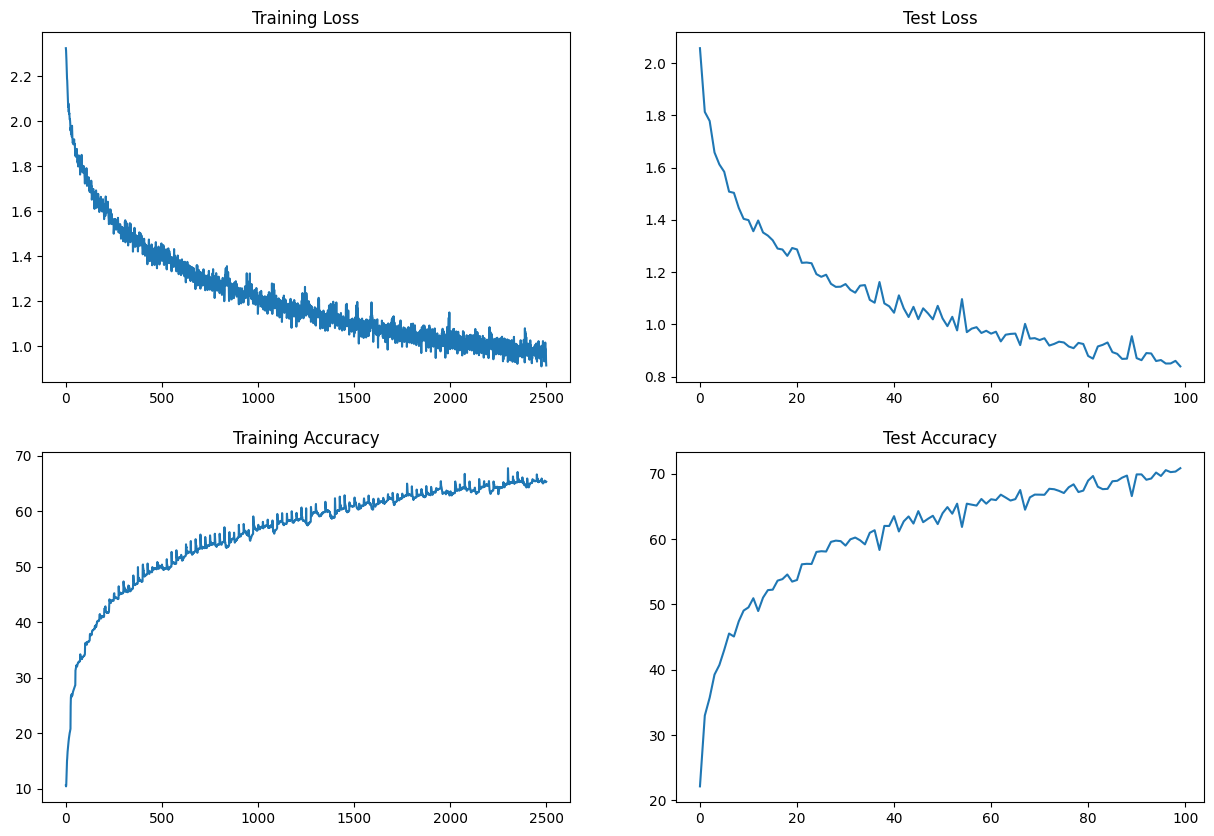

In [8]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")